# NEURONAL NETWORKS

### IMPORT LYBRARIES AND TRANSFORM DATA

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
import os

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\Marcos\Anaconda3\envs\tfg\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
arr1 = np.loadtxt('dades1.txt')## Numpy: array
arr1*=3.6
seconds=np.arange(0,len(arr1)/10,0.1)
data1=pd.DataFrame(data=arr1,index=seconds,columns=['km/h'])
data1.index.name='s'

data2 = pd.read_csv('dades2.txt',sep='\t',header=5)
data2=data2.set_index('s')
data2.rename(columns={'mph':'km/h'},inplace=True)
arr2=data2.to_numpy()
data2.loc[:,'km/h']*=1.609 ## mph to km/h
arr2 =data2['km/h'].to_numpy()


data3= pd.read_csv('dades3.txt',sep='\t',header=5)
data3=data3.set_index('s')
data3.loc[:,'mph']*=1.609 ## mph to km/h
data3.rename(columns={'mph':'km/h'},inplace=True)
arr3 =data3['km/h'].to_numpy() ## Array 


In [3]:
## Divide train and validation
##The function below returns the above described windows of time for the model to train on. The parameter history_size is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The target_size is the label that needs to be predicted.


## Function to plot true value, train and test
def create_time_steps(length):
  return list(range(-length, 0))
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  plt.ylabel('Velocity: km/h')
  return plt


**RECURRENT NEURONAL NETWORK**

**ATTEMPT 0**

In [4]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
## The function below returns the above described windows of time for the model to train on. The parameter **history_size** is the size of the past window of information. The target_size is how far in the future does the model need to learn to predict. The target_size is the label that needs to be predicted.

  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [4]:
TRAIN_SPLIT=2000
tf.random.set_seed(13)

univariate_past_history = 200 ### It observs last 200 values, it predicts the next one
univariate_future_target = 0 ##Position of desired future target

x_train_uni, y_train_uni = univariate_data(arr2, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(arr2, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

BATCH_SIZE = 300 ##Amount of time allowed to the computer to do the calculations
BUFFER_SIZE = 10000

## Create tensor to work properly with tf: Training and validation
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

## Let's start with 1 layer
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)])
## optimizer and loss
model.compile(optimizer='adam', loss='mae')

In [5]:
EVALUATION_INTERVAL = 200
EPOCHS = 10 ## Amount of times model is going to be trainded

## Lets fit the model
model1=model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)


Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 31s 153ms/step - loss: 6.8895 - val_loss: 4.3602
Epoch 2/10
200/200 [==============================] - 22s 109ms/step - loss: 6.2819 - val_loss: 3.8848
Epoch 3/10
200/200 [==============================] - 21s 103ms/step - loss: 5.6842 - val_loss: 3.2287
Epoch 4/10
200/200 [==============================] - 21s 104ms/step - loss: 5.1849 - val_loss: 2.8409
Epoch 5/10
200/200 [==============================] - 21s 103ms/step - loss: 4.7871 - val_loss: 2.4960
Epoch 6/10
200/200 [==============================] - 21s 105ms/step - loss: 4.4173 - val_loss: 2.1699
Epoch 7/10
200/200 [==============================] - 21s 104ms/step - loss: 4.0663 - val_loss: 1.8630
Epoch 8/10
200/200 [==============================] - 21s 105ms/step - loss: 3.7450 - val_loss: 1.5838
Epoch 9/10
200/200 [==============================] - 22s 109ms/step - loss: 3.4310 - val_loss: 1.3370
Epoch 10/10
200/200 [=========

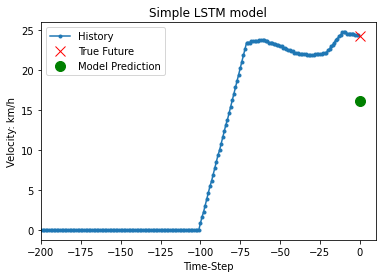

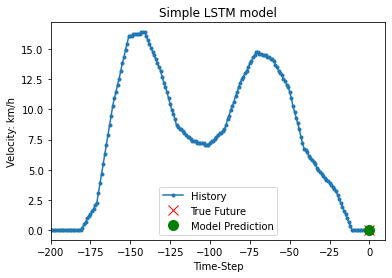

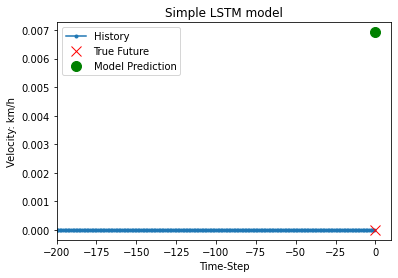

In [6]:
## Plot of predictions
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    model.predict(x)[0]], 0, 'Simple LSTM model')
    
  
  plot.show()


In [5]:
## Plot of loss function
def plot_train_history(history, title,attempt,optimizer):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.xlabel('EPOCHS')
  plt.legend()
  plt.ylabel(optimizer)
  plt.savefig('{}.png'.format(attempt))
  plt.show()
  

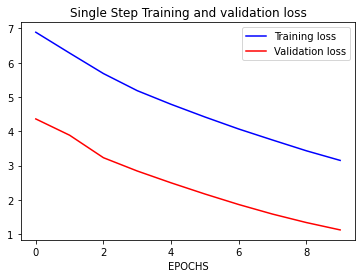

In [8]:
plot_train_history(model1,
                   'Single Step Training and validation loss')

##  MULTIVARIATE STEP

**ATTEMPT 1**

In [6]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  

  return np.array(data),np.array(labels)

In [10]:
past_history = 720
future_target = 72
STEP = 6
dataframe=pd.concat([data2.shift(1),data2], axis=1)
dataframe.columns = ['t-0.1', 't+0.1']
dataframe=dataframe.dropna()
dataset=dataframe.values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)




train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [7]:
def multi_step_plot(history, true_future, prediction,i):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.title('Predicitons for the future {} values'.format(future_target))
  plt.xlabel('Time steps')
  plt.ylabel('Velocity in km/h')
  plt.savefig('hola{}.png'.format(i))
  plt.show()


In [12]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)


(300, 72)
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 65s 326ms/step - loss: 5.0373 - val_loss: 5.0540
Epoch 2/10
200/200 [==============================] - 58s 289ms/step - loss: 3.8599 - val_loss: 5.5104
Epoch 3/10
200/200 [==============================] - 57s 285ms/step - loss: 4.4893 - val_loss: 5.3030
Epoch 4/10
200/200 [==============================] - 54s 269ms/step - loss: 3.3524 - val_loss: 4.9020
Epoch 5/10
200/200 [==============================] - 59s 294ms/step - loss: 2.7216 - val_loss: 5.2103
Epoch 6/10
200/200 [==============================] - 61s 304ms/step - loss: 1.7219 - val_loss: 5.3583
Epoch 7/10
200/200 [==============================] - 58s 291ms/step - loss: 1.3039 - val_loss: 5.7366
Epoch 8/10
200/200 [==============================] - 56s 281ms/step - loss: 1.2074 - val_loss: 5.2727
Epoch 9/10
200/200 [==============================] - 56s 282ms/step - loss: 1.1200 - val_loss: 5.3983
Epoch 10/10
200/200 

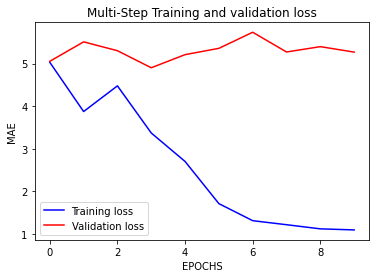

3207/3207 [==============================] - 3s 803us/sample - loss: 5.3599
MAE average value = 5.36


In [31]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss',1,"MAE")
scores = multi_step_model.evaluate(x_val_multi, y_val_multi, verbose=1)
print(f'MAE average value = {scores:.2f}')

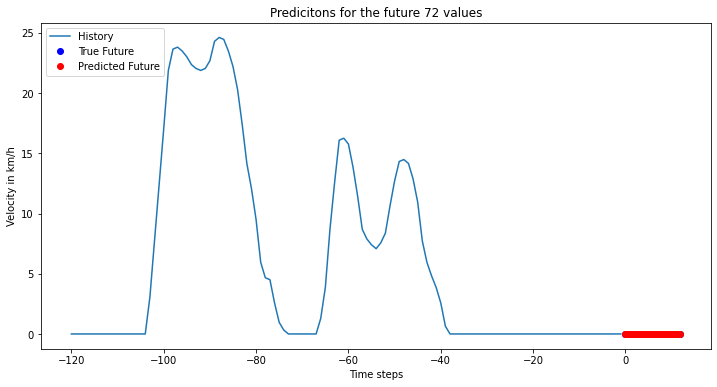

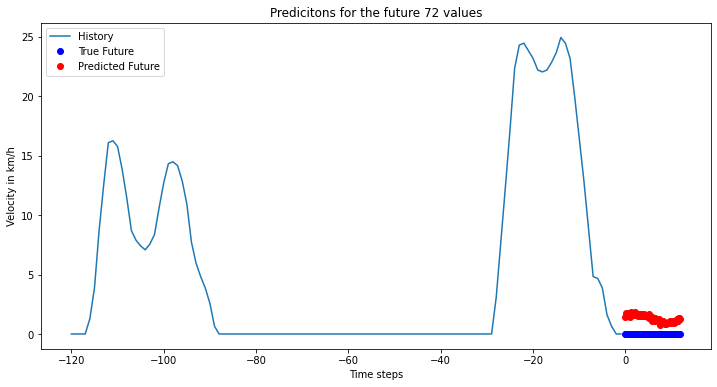

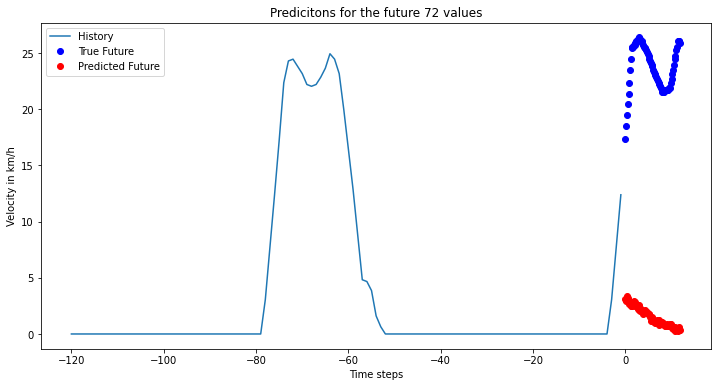

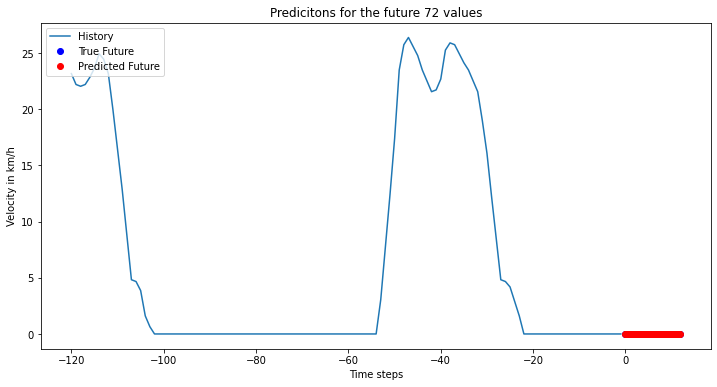

In [14]:
i=1
for x, y in val_data_multi.take(4):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0],i)
  i+=1

**ATTEMPT 2**

In [220]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

attempt2 = tf.keras.models.Sequential()
attempt2.add(tf.keras.layers.LSTM(50,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt2.add(tf.keras.layers.LSTM(25, activation='relu'))
attempt2.add(tf.keras.layers.Dense(72))

attempt2.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
for x, y in val_data_multi.take(1):
  print (attempt2.predict(x).shape)

(300, 72)


In [19]:
attempt2_history = attempt2.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 90s 449ms/step - loss: 16.0978 - val_loss: 5.1901
Epoch 2/10
200/200 [==============================] - 86s 428ms/step - loss: 6.3026 - val_loss: 5.1569
Epoch 3/10
200/200 [==============================] - 88s 441ms/step - loss: 6.2379 - val_loss: 5.1247
Epoch 4/10
200/200 [==============================] - 79s 396ms/step - loss: 6.2347 - val_loss: 5.0926
Epoch 5/10
200/200 [==============================] - 89s 447ms/step - loss: 6.1516 - val_loss: 5.0606
Epoch 6/10
200/200 [==============================] - 89s 443ms/step - loss: 6.1746 - val_loss: 5.0286
Epoch 7/10
200/200 [==============================] - 87s 434ms/step - loss: 5.9731 - val_loss: 4.9980
Epoch 8/10
200/200 [==============================] - 106s 529ms/step - loss: 6.0114 - val_loss: 4.9673
Epoch 9/10
200/200 [==============================] - 108s 540ms/step - loss: 5.9301 - val_loss: 4.9372
Epoch 10/10
200/200 [======

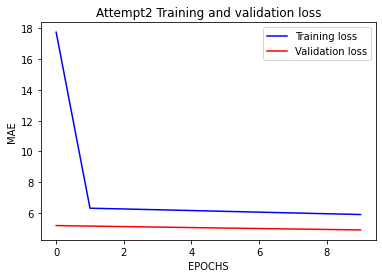

3207/3207 [==============================] - 3s 1ms/sample - loss: 2.8552
MAE average value = 2.86


In [131]:
plot_train_history(attempt2_history, 'Attempt2 Training and validation loss',2,'MAE')
scores = attempt2.evaluate(x_val_multi, y_val_multi, verbose=1)
print(f'MAE average value = {scores:.2f}')

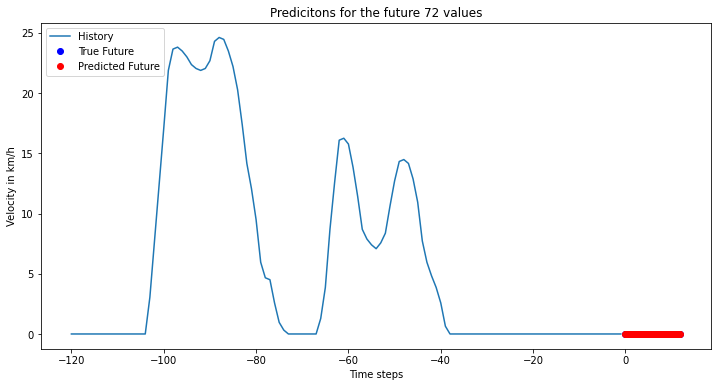

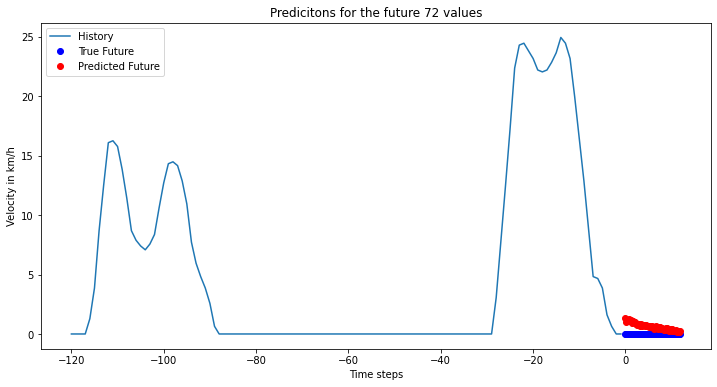

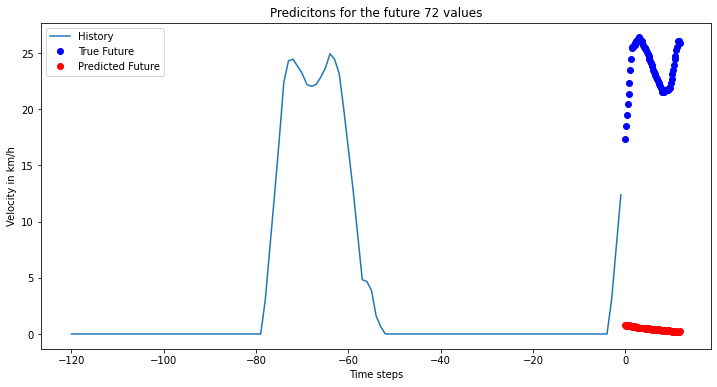

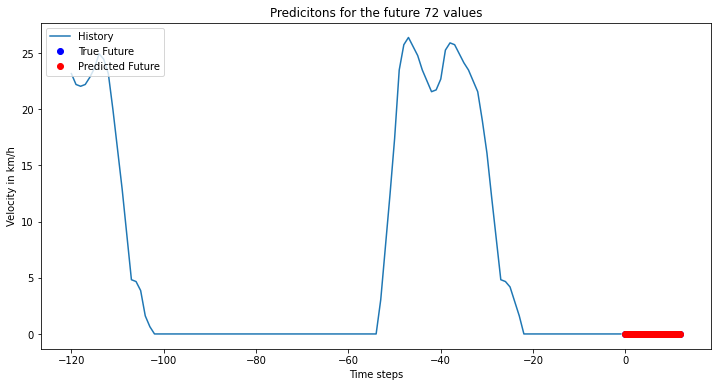

In [37]:
i=1
for x, y in val_data_multi.take(4):
  multi_step_plot(x[0], y[0], attempt2.predict(x)[0],i)
  i+=1

**ATTEMPT 3: STANDARIZING DATA**

In [ ]:
plt.plot(arr2)

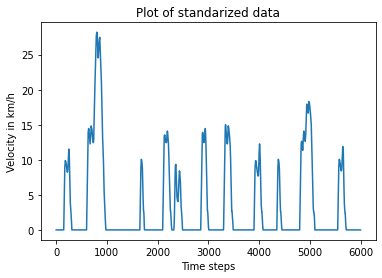

In [70]:
arr2_mean = arr2.mean()
arr2_std = arr2.std()
standarized = arr2*(arr2_mean)/arr2_std
seconds2=np.arange(0,len(arr2)/10,0.1)
df_stand=pd.DataFrame(data=standarized,index=seconds2,columns=['km/h'])
df_stand.index.name='s'
plt.plot(standarized)
plt.xlabel('Time steps')
plt.ylabel('Velocity in km/h')
plt.title('Plot of standarized data')a
plt.savefig('Standarized.png')

In [127]:
past_history = 720
future_target = 72
STEP = 6
dataframe=pd.concat([df_stand.shift(1),df_stand], axis=1)
dataframe.columns = ['t-0.1', 't+0.1']
dataframe=dataframe.dropna()
dataset=dataframe.values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)




train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [130]:
attempt3 = tf.keras.models.Sequential()
attempt3.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt3.add(tf.keras.layers.LSTM(16, activation='relu'))
attempt3.add(tf.keras.layers.Dense(72))

attempt3.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
for x, y in val_data_multi.take(1):
  print (attempt3.predict(x).shape)
attempt3_history = attempt3.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

(300, 72)
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 76s 381ms/step - loss: 13846.4694 - val_loss: 2.8965
Epoch 2/10
200/200 [==============================] - 65s 326ms/step - loss: 680772.8786 - val_loss: 2.8869
Epoch 3/10
200/200 [==============================] - 63s 316ms/step - loss: 3.7076 - val_loss: 2.8727
Epoch 4/10
200/200 [==============================] - 66s 329ms/step - loss: 106980.9703 - val_loss: 2.8653
Epoch 5/10
200/200 [==============================] - 60s 299ms/step - loss: 3.7896 - val_loss: 2.8392
Epoch 6/10
200/200 [==============================] - 60s 298ms/step - loss: 3.3525 - val_loss: 2.8057
Epoch 7/10
200/200 [==============================] - 57s 284ms/step - loss: 7567.7519 - val_loss: 2.6405
Epoch 8/10
200/200 [==============================] - 60s 302ms/step - loss: 2499.6765 - val_loss: 2.5518
Epoch 9/10
200/200 [==============================] - 70s 350ms/step - loss: 1.8920 - val_loss: 2.5335


In [132]:
destand=arr2_std/(arr2_mean)
def plot_standard(history, title,attempt,optimizer):
  destand=arr2_std/(arr2_mean) #Value we have to multiply data to remove standardization
  loss = np.array(history.history['loss'])*destand
  val_loss = np.array(history.history['val_loss'])*destand

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.xlabel('EPOCHS')
  plt.legend()
  plt.ylabel(optimizer)
  plt.savefig('{}.png'.format(attempt))
  plt.show()


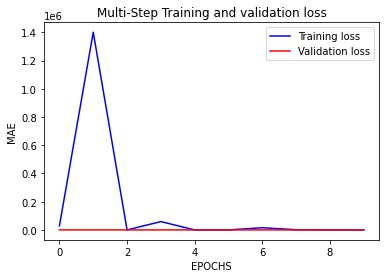

3207/3207 [==============================] - 3s 851us/sample - loss: 3.0336
MAE average value = 5.33


In [137]:
plot_standard(attempt3_history, 'Multi-Step Training and validation loss',3,"MAE")
destand=arr2_std/(arr2_mean)
scores = attempt3.evaluate(x_val_multi, y_val_multi, verbose=1)*destand
print(f'MAE average value = {scores:.2f}')

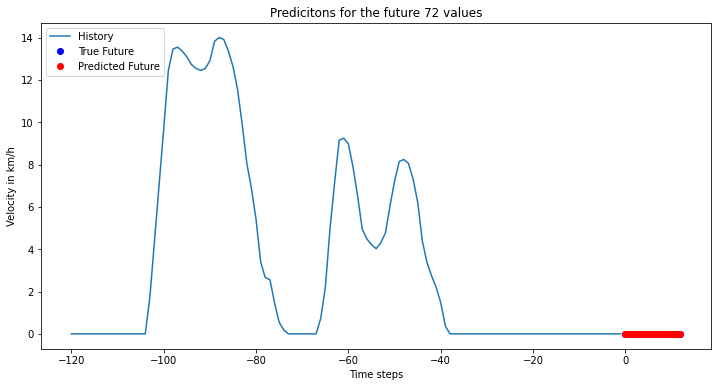

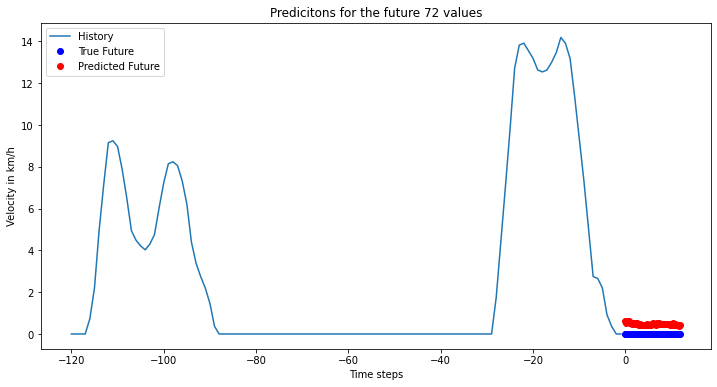

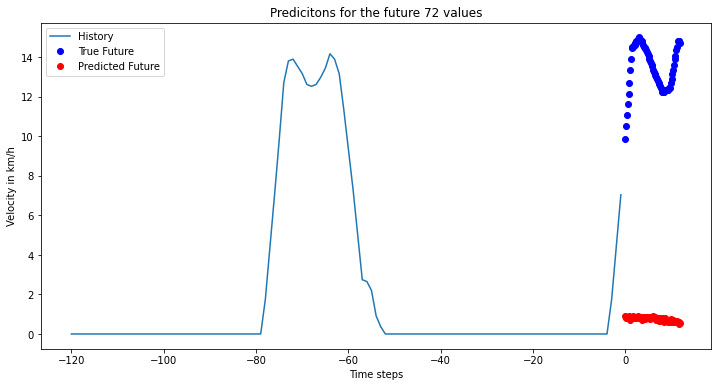

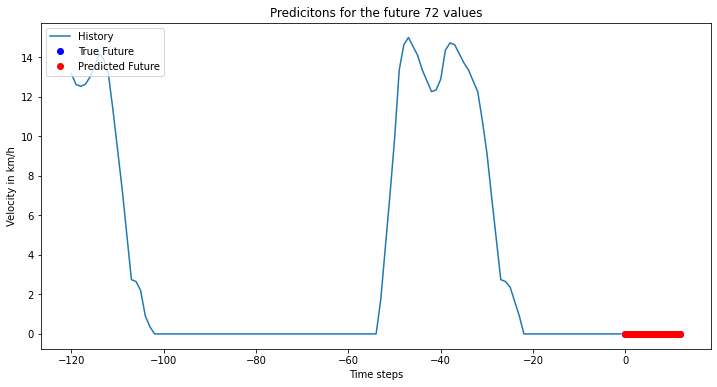

In [136]:
i=1
for x, y in val_data_multi.take(4
                               ):
  multi_step_plot(x[0], y[0], attempt3.predict(x)[0],i)
  i+=1

**ATTEMPT 4: Normalization of Data**

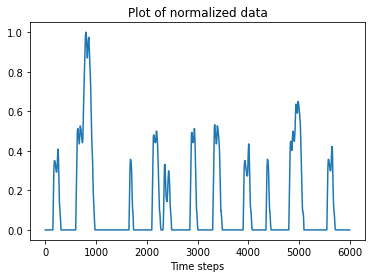

In [188]:
maxi=np.amax(arr2)
mini=np.amin(arr2)
normalized=(arr2-mini)/(maxi-mini)
df_norm=pd.DataFrame(data=normalized,index=seconds2,columns=['km/h'])
df_norm.index.name='s'
plt.plot(normalized)
plt.xlabel('Time steps')
plt.title('Plot of normalized data')
plt.savefig('Standarized.png')
plt.show()


In [139]:
past_history = 720
future_target = 72
STEP = 6
dataframe=pd.concat([df_norm.shift(1),df_norm], axis=1)
dataframe.columns = ['t-0.1', 't+0.1']
dataframe=dataframe.dropna()
dataset=dataframe.values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)




train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [141]:
attempt4 = tf.keras.models.Sequential()
attempt4.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt4.add(tf.keras.layers.LSTM(16, activation='relu'))
attempt4.add(tf.keras.layers.Dense(72))

attempt4.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
for x, y in val_data_multi.take(1):
  print (attempt4.predict(x).shape)
attempt4_history = attempt4.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)


(300, 72)
Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 65s 325ms/step - loss: 37698.0506 - val_loss: 0.1322
Epoch 2/10
200/200 [==============================] - 60s 299ms/step - loss: 0.0408 - val_loss: 0.1378
Epoch 3/10
200/200 [==============================] - 62s 310ms/step - loss: 0.0355 - val_loss: 0.1262
Epoch 4/10
200/200 [==============================] - 59s 296ms/step - loss: 0.0287 - val_loss: 0.1391
Epoch 5/10
200/200 [==============================] - 64s 320ms/step - loss: 0.0257 - val_loss: 0.1343
Epoch 6/10
200/200 [==============================] - 61s 304ms/step - loss: 0.0243 - val_loss: 0.1293
Epoch 7/10
200/200 [==============================] - 57s 286ms/step - loss: 0.0235 - val_loss: 0.1461
Epoch 8/10
200/200 [==============================] - 57s 286ms/step - loss: 0.0228 - val_loss: 0.1439
Epoch 9/10
200/200 [==============================] - 60s 301ms/step - loss: 0.0220 - val_loss: 0.1425
Epoch 10/10
200/

In [169]:
## Plot of loss function
def normal_plot(history, title,attempt,optimizer):
  loss = history.history['loss'][1:] #We supress first value, to high and it distrosionates plot
  val_loss = history.history['val_loss'][1:]
  loss= np.array(loss)*maxi
  val_loss=np.array(val_loss)*maxi
  epochs = range(2,11)

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.xlabel('EPOCHS')
  plt.legend()
  plt.ylabel(optimizer)
  plt.savefig('{}.png'.format(attempt))
  plt.show()

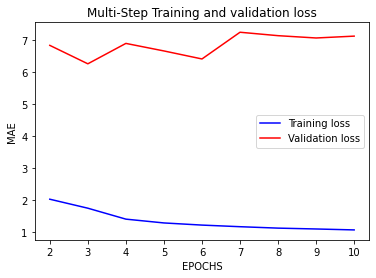

3207/3207 [==============================] - 3s 955us/sample - loss: 0.1440
MAE average value = 7.13


In [171]:
normal_plot(attempt4_history, 'Multi-Step Training and validation loss',3,"MAE")
scores = attempt4.evaluate(x_val_multi, y_val_multi, verbose=1)*maxi
print(f'MAE average value = {scores:.2f}')

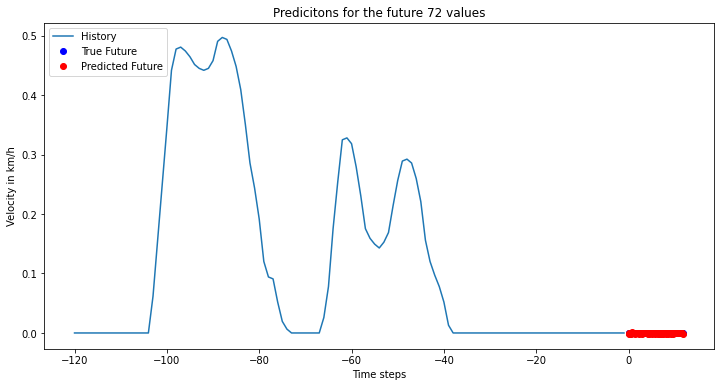

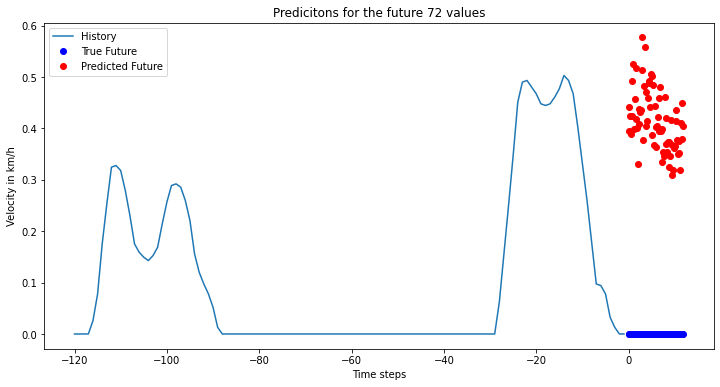

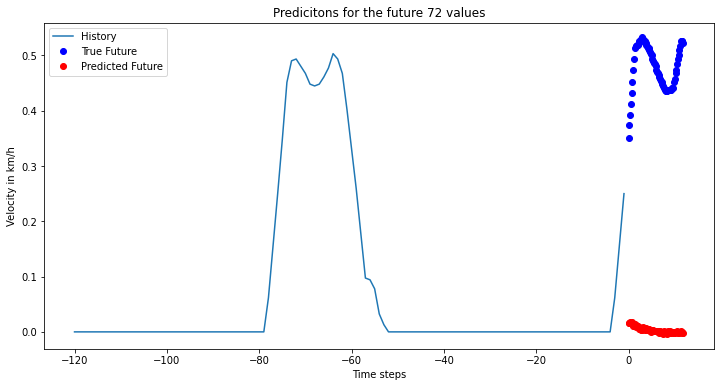

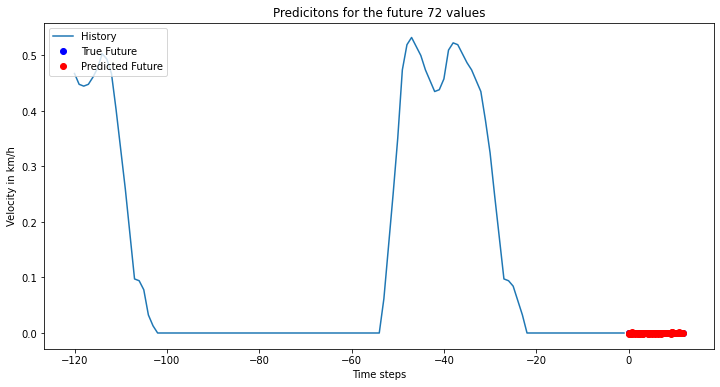

In [172]:
i=1
for x, y in val_data_multi.take(4
                               ):
  multi_step_plot(x[0], y[0], attempt4.predict(x)[0],i)
  i+=1

**ATTEMPT 5**


In [199]:
past_history = 720
future_target = 50
STEP = 20
TRAIN_SPLIT=2000
tf.random.set_seed(13)
BATCH_SIZE = 300 
BUFFER_SIZE = 10000##Amount of time allowed to the computer to do the calcula
EVALUATION_INTERVAL = 200
EPOCHS = 10## Amount of times model is going to be trainded


dataframe=pd.concat([data2.shift(1),data2], axis=1)
dataframe.columns = ['t-0.1', 't+0.1']
dataframe=dataframe.dropna()
dataset=dataframe.values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [200]:
x_train_multi.shape[-2:]

(36, 2)

In [201]:
attempt5 = tf.keras.models.Sequential()
attempt5.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt5.add(tf.keras.layers.LSTM(16, activation='sigmoid'))
attempt5.add(tf.keras.layers.Dense(50))
attempt5.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
for x, y in val_data_multi.take(1):
  print (attempt5.predict(x).shape)

(300, 50)


In [202]:

## Lets fit the model
attempt5_history = attempt5.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 21s 105ms/step - loss: 227.6028 - val_loss: 86.3804
Epoch 2/10
200/200 [==============================] - 21s 105ms/step - loss: 183.1796 - val_loss: 75.3799
Epoch 3/10
200/200 [==============================] - 22s 108ms/step - loss: 151.3751 - val_loss: 69.6649
Epoch 4/10
200/200 [==============================] - 16s 79ms/step - loss: 124.0619 - val_loss: 70.5358
Epoch 5/10
200/200 [==============================] - 15s 77ms/step - loss: 105.1477 - val_loss: 72.7149
Epoch 6/10
200/200 [==============================] - 15s 76ms/step - loss: 87.6689 - val_loss: 74.7058
Epoch 7/10
200/200 [==============================] - 15s 76ms/step - loss: 72.5067 - val_loss: 81.6775
Epoch 8/10
200/200 [==============================] - 16s 78ms/step - loss: 60.8839 - val_loss: 89.8411
Epoch 9/10
200/200 [==============================] - 15s 77ms/step - loss: 49.9475 - val_loss: 104.0267
Epoch 10/10


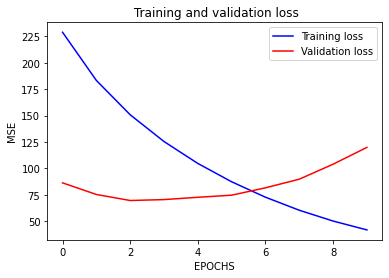

In [249]:
plot_train_history(attempt5_history, ' Training and validation loss',5,'MSE')

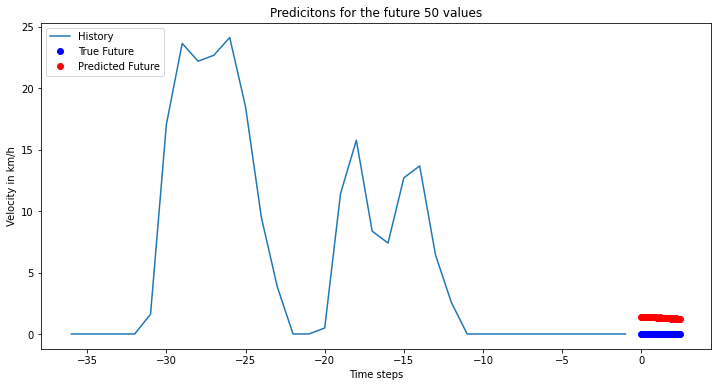

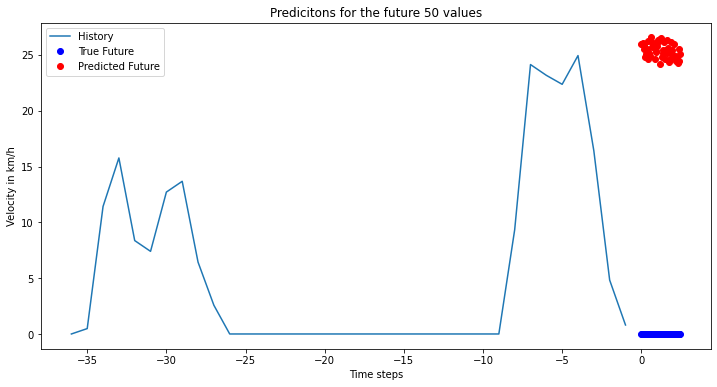

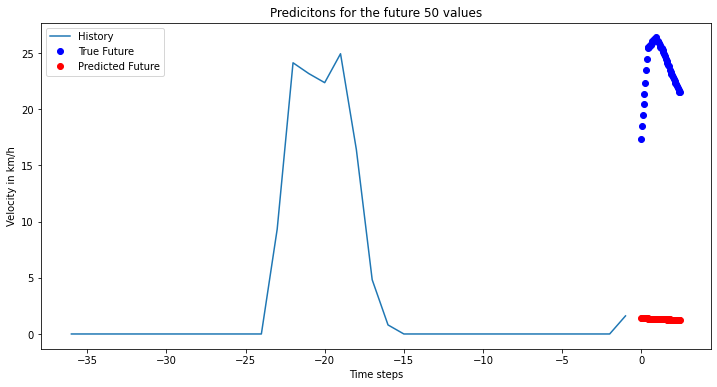

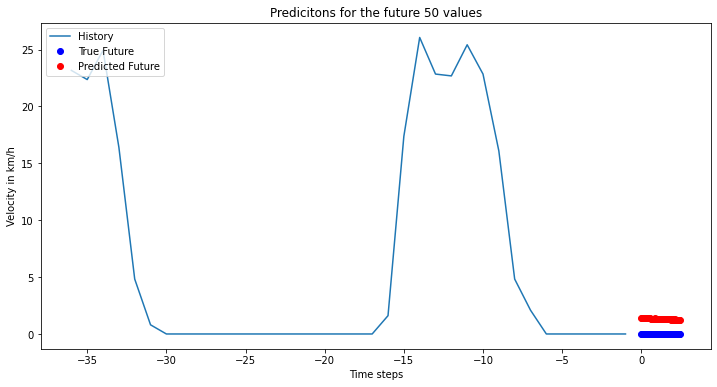

In [204]:
i=1
for x, y in val_data_multi.take(4
                               ):
  multi_step_plot(x[0], y[0], attempt5.predict(x)[0],i)
  i+=1

**ATTEMPT 6**

In [243]:
past_history = 720
future_target = 72
STEP = 6
TRAIN_SPLIT=3000
tf.random.set_seed(13)
BATCH_SIZE = 300 
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 200
EPOCHS = 3## Amount of times model is going to be trainded



dataframe=pd.concat([data2.shift(1),data2], axis=1)
dataframe.columns = ['t-0.1', 't+0.1']
dataframe=dataframe.dropna()
dataset=dataframe.values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)




train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [244]:


attempt6 = tf.keras.models.Sequential()
attempt6.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt6.add(tf.keras.layers.LSTM(16, activation='relu',return_sequences=True))
attempt6.add(tf.keras.layers.LSTM(16, activation='relu'))
attempt6.add(tf.keras.layers.Dense(72))

attempt6.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
for x, y in val_data_multi.take(1):
  print (attempt6.predict(x).shape)

(300, 72)


In [253]:
train_data_multi

<RepeatDataset shapes: ((None, 120, 2), (None, 72)), types: (tf.float64, tf.float64)>

In [245]:

## Lets fit the model
attempt6_history = attempt6.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/3
200/200 [==============================] - 104s 521ms/step - loss: 356.5603 - val_loss: 91.5778
Epoch 2/3
200/200 [==============================] - 85s 426ms/step - loss: 191.6935 - val_loss: 87.6901
Epoch 3/3
200/200 [==============================] - 91s 455ms/step - loss: 167.8188 - val_loss: 82.3068


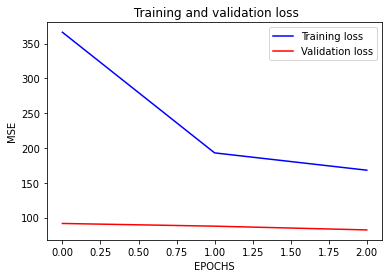

In [251]:
plot_train_history(attempt6_history, ' Training and validation loss',6,'MSE')

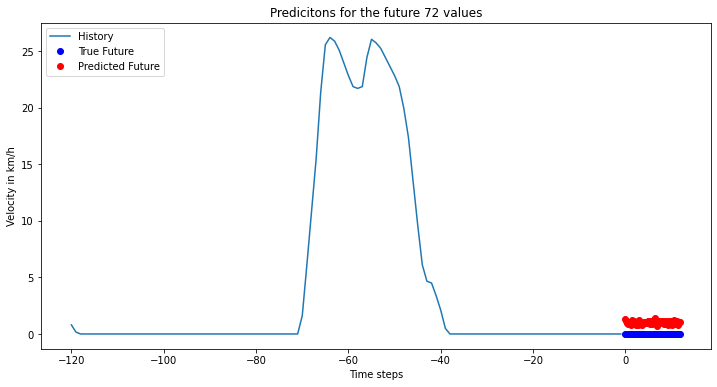

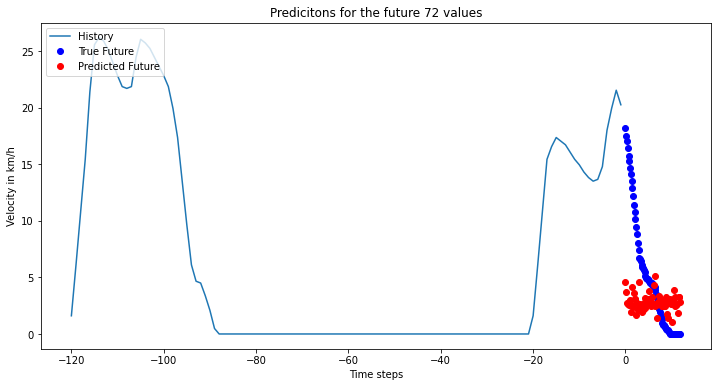

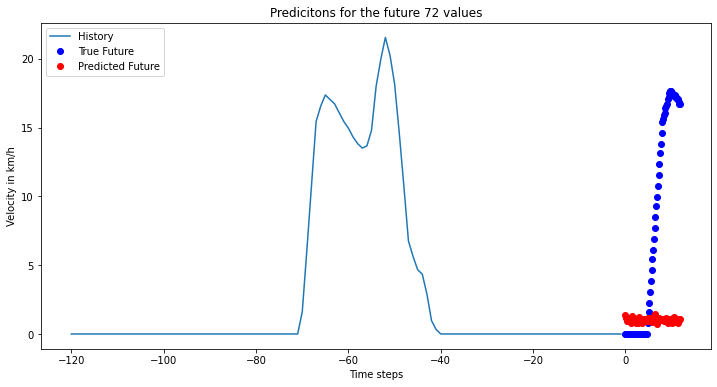

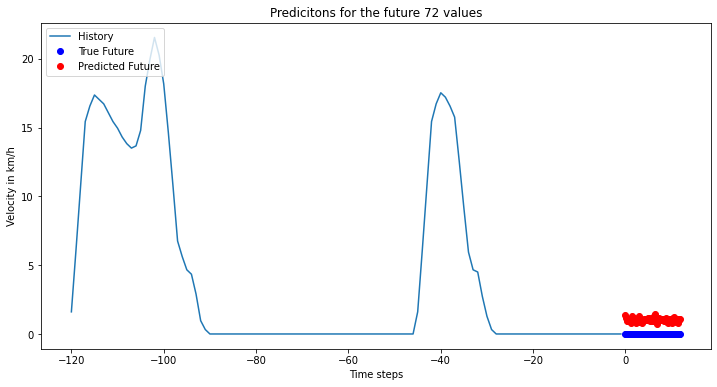

In [252]:
i=1
for x, y in val_data_multi.take(4
                               ):
  multi_step_plot(x[0], y[0], attempt6.predict(x)[0],i)
  i+=1

**ATTEMPT 7**

In [258]:
past_history = 800
future_target = 72
STEP = 6
TRAIN_SPLIT=4000
tf.random.set_seed(13)
BATCH_SIZE = 300 
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 400
EPOCHS = 3## Amount of times model is going to be trainded



dataframe=pd.concat([data2.shift(1),data2], axis=1)
dataframe.columns = ['t-0.1', 't+0.1']
dataframe=dataframe.dropna()
dataset=dataframe.values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)




train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [259]:
attempt7 = tf.keras.models.Sequential()
attempt7.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt7.add(tf.keras.layers.LSTM(16, activation='relu',return_sequences=True))
attempt7.add(tf.keras.layers.LSTM(16, activation='relu'))
attempt7.add(tf.keras.layers.Dense(72))

attempt7.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
for x, y in val_data_multi.take(1):
  print (attempt7.predict(x).shape)

(300, 72)


In [260]:
attempt7_history = attempt7.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 400 steps, validate for 50 steps
Epoch 1/3
400/400 [==============================] - 226s 566ms/step - loss: 738.2896 - val_loss: 114.4414
Epoch 2/3
400/400 [==============================] - 211s 527ms/step - loss: 81.6046 - val_loss: 92.6517
Epoch 3/3
400/400 [==============================] - 226s 565ms/step - loss: 53.4307 - val_loss: 91.2344


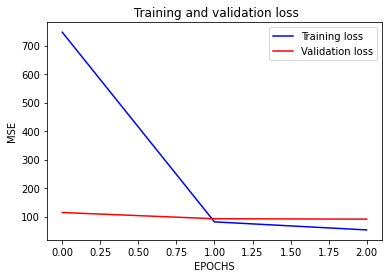

1127/1127 [==============================] - 2s 1ms/sample - loss: 94.6723
MsE average value = 94.67


In [263]:
plot_train_history(attempt7_history, ' Training and validation loss',6,'MSE')
scores = attempt7.evaluate(x_val_multi, y_val_multi, verbose=1)
print(f'MsE average value = {scores:.2f}')

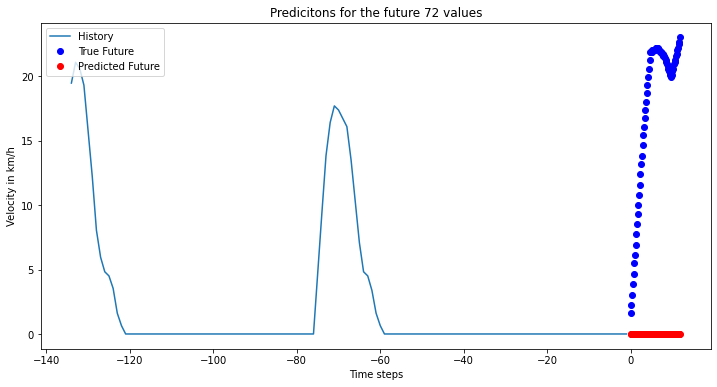

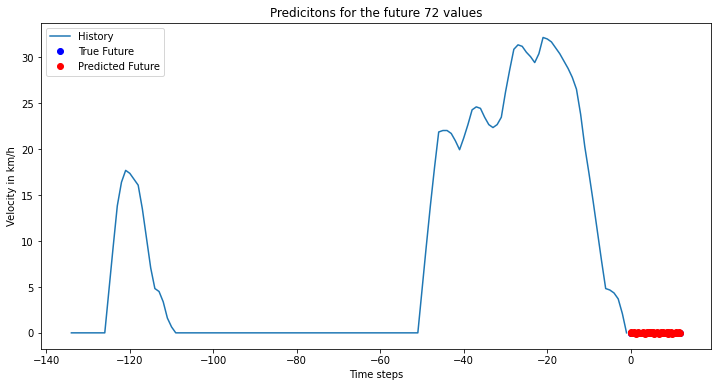

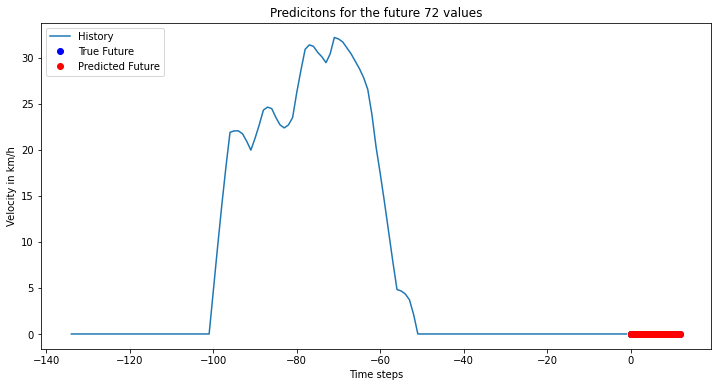

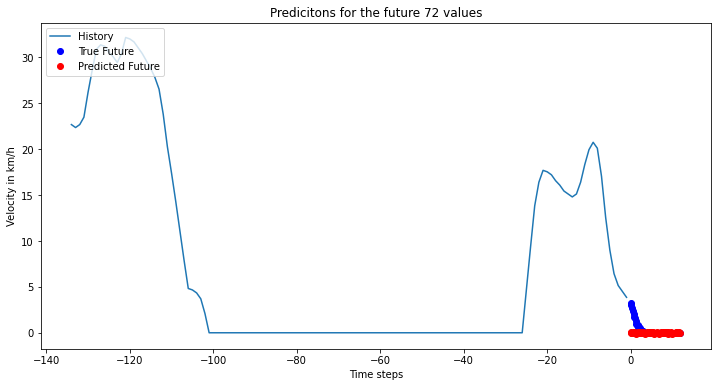

In [264]:
i=1
for x, y in val_data_multi.take(4
                               ):
  multi_step_plot(x[0], y[0], attempt6.predict(x)[0],i)
  i+=1

**ATTEMPT 8**

In [265]:
attempt8 = tf.keras.models.Sequential()
attempt8.add(tf.keras.layers.LSTM(50,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt8.add(tf.keras.layers.LSTM(30, activation='relu',return_sequences=True))
attempt8.add(tf.keras.layers.LSTM(25, activation='relu',return_sequences=True))
attempt8.add(tf.keras.layers.LSTM(25, activation='relu'))
attempt8.add(tf.keras.layers.Dense(72))

attempt8.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
for x, y in val_data_multi.take(1):
  print (attempt8.predict(x).shape)

(300, 72)


In [266]:
attempt8_history = attempt8.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 400 steps, validate for 50 steps
Epoch 1/3
400/400 [==============================] - 543s 1s/step - loss: nan - val_loss: nan
Epoch 2/3
 13/400 [..............................] - ETA: 8:18 - loss: nan

KeyboardInterrupt: 

**ATTEMPT 9**

In [268]:
attempt9 = tf.keras.models.Sequential()
attempt9.add(tf.keras.layers.LSTM(50,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt9.add(tf.keras.layers.LSTM(35, activation='relu',return_sequences=True))
attempt9.add(tf.keras.layers.LSTM(20, activation='relu'))
attempt9.add(tf.keras.layers.Dense(72))

attempt9.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
for x, y in val_data_multi.take(1):
  print (attempt9.predict(x).shape)

(300, 72)


In [269]:
attempt9_history = attempt9.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 400 steps, validate for 50 steps
Epoch 1/3
400/400 [==============================] - 410s 1s/step - loss: 96.6593 - val_loss: 79.0380
Epoch 2/3
400/400 [==============================] - 394s 984ms/step - loss: 21.8607 - val_loss: 119.3770
Epoch 3/3
400/400 [==============================] - 420s 1s/step - loss: nan - val_loss: nan


**ATTEMPT 10**

In [9]:
past_history = 800
future_target = 72
STEP = 6
TRAIN_SPLIT=4000
tf.random.set_seed(13)
BATCH_SIZE = 300 
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 500
EPOCHS = 5# Amount of times model is going to be trainded



dataframe=pd.concat([data2.shift(1),data2], axis=1)
dataframe.columns = ['t-0.1', 't+0.1']
dataframe=dataframe.dropna()
dataset=dataframe.values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)




train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [24]:
attempt10 = tf.keras.models.Sequential()
attempt10.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt10.add(tf.keras.layers.LSTM(16, activation='relu',return_sequences=True))
attempt10.add(tf.keras.layers.LSTM(16, activation='relu'))
attempt10.add(tf.keras.layers.Dense(72))

attempt10.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'), loss='mse')

In [290]:
attempt10_history = attempt10.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/5
500/500 [==============================] - 303s 607ms/step - loss: 5756251851238.9990 - val_loss: 145.7962
Epoch 2/5
500/500 [==============================] - 275s 549ms/step - loss: 112.3526 - val_loss: 138.4529
Epoch 3/5
500/500 [==============================] - 271s 543ms/step - loss: 108.7641 - val_loss: 131.6490
Epoch 4/5
500/500 [==============================] - 272s 543ms/step - loss: 105.4890 - val_loss: 125.3137
Epoch 5/5
500/500 [==============================] - 283s 567ms/step - loss: 102.6623 - val_loss: 119.4155


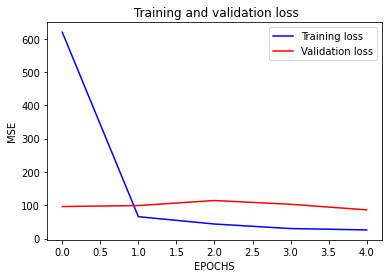

1127/1127 [==============================] - 2s 2ms/sample - loss: 124.0809
MsE average value = 124.08


In [291]:
plot_train_history(attempt10_history, ' Training and validation loss',6,'MSE')
scores = attempt10.evaluate(x_val_multi, y_val_multi, verbose=1)
print(f'MsE average value = {scores:.2f}')

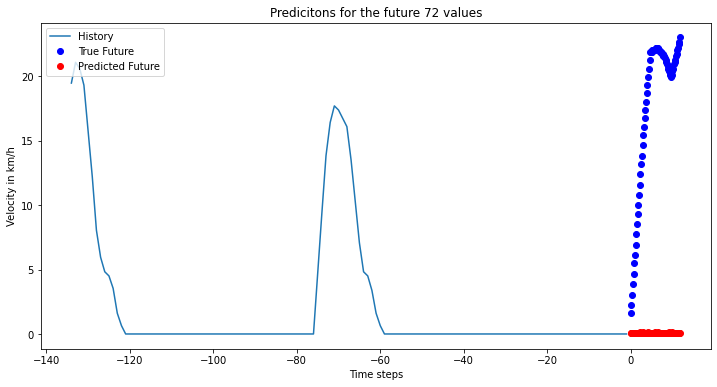

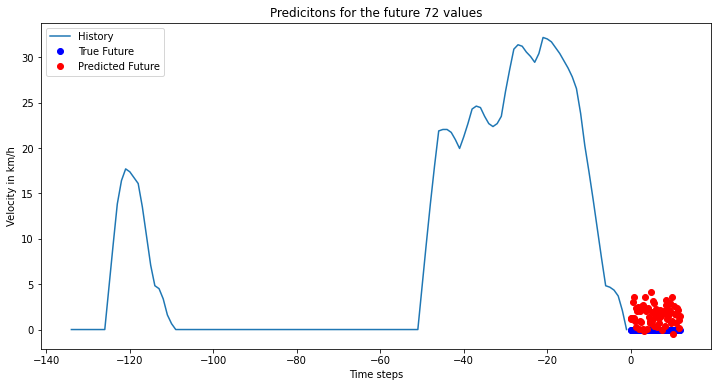

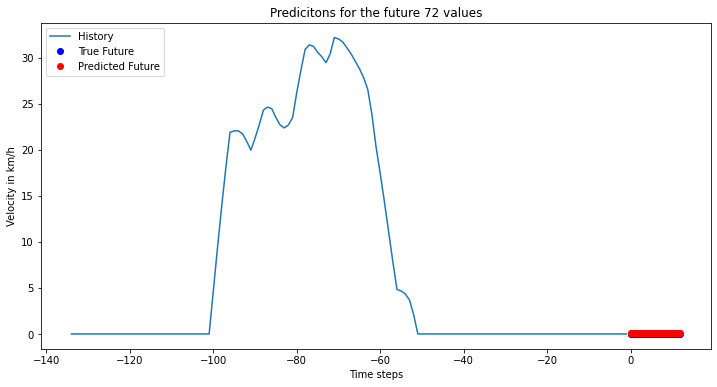

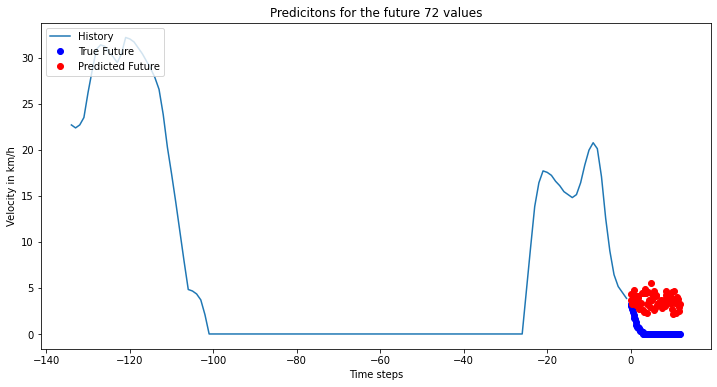

In [292]:
i=1
for x, y in val_data_multi.take(4
                               ):
  multi_step_plot(x[0], y[0], attempt10.predict(x)[0],i)
  i+=1

**ATTEMPT 11**

In [21]:
EPOCHS=3
attempt11 = tf.keras.models.Sequential()
attempt11.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt11.add(tf.keras.layers.LSTM(16, activation='sigmoid',return_sequences=True))
attempt11.add(tf.keras.layers.LSTM(16, activation='sigmoid'))
attempt11.add(tf.keras.layers.Dense(72))

attempt11.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'), loss='mse')

In [32]:
attempt11_history = attempt11.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/3
 25/500 [>.............................] - ETA: 5:17 - loss: 27.5180

KeyboardInterrupt: 

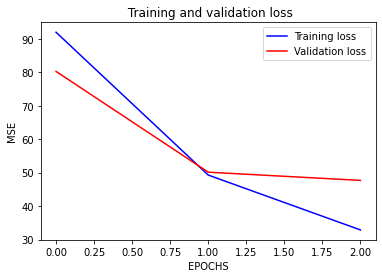

1127/1127 [==============================] - 3s 3ms/sample - loss: 49.9950
MsE average value = 50.00


In [25]:
plot_train_history(attempt11_history, ' Training and validation loss',6,'MSE')
scores = attempt11.evaluate(x_val_multi, y_val_multi, verbose=1)
print(f'MsE average value = {scores:.2f}')

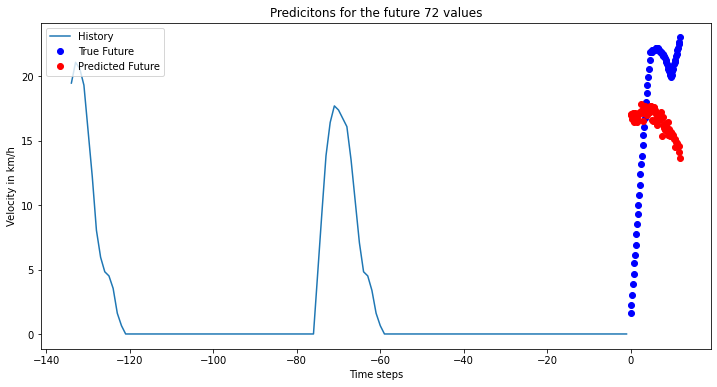

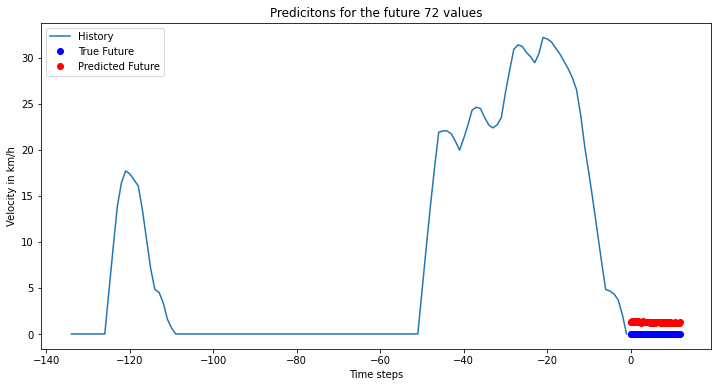

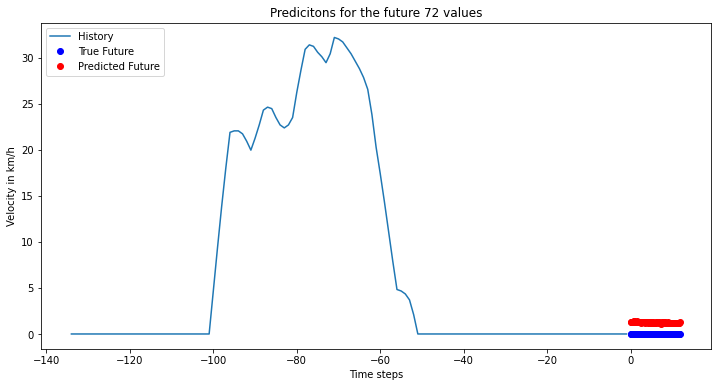

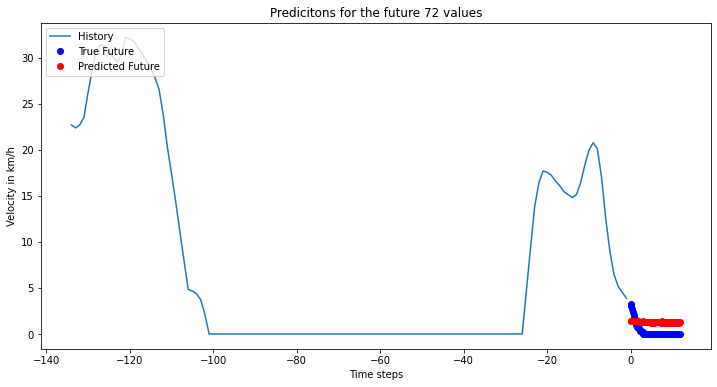

In [26]:
i=1
for x, y in val_data_multi.take(4
                               ):
  multi_step_plot(x[0], y[0], attempt11.predict(x)[0],i)
  i+=1

**ATTEMPT 12**

In [28]:
EPOCHS=3
attempt12 = tf.keras.models.Sequential()
attempt12.add(tf.keras.layers.LSTM(50,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt12.add(tf.keras.layers.LSTM(30, activation='sigmoid',return_sequences=True))
attempt12.add(tf.keras.layers.LSTM(25, activation='sigmoid'))
attempt12.add(tf.keras.layers.Dense(72))

attempt12.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'), loss='mse')

In [29]:
attempt12_history = attempt12.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/3
500/500 [==============================] - 458s 916ms/step - loss: 86.4949 - val_loss: 57.8028
Epoch 2/3
500/500 [==============================] - 503s 1s/step - loss: 39.8741 - val_loss: 34.1296
Epoch 3/3
500/500 [==============================] - 576s 1s/step - loss: 26.4555 - val_loss: 39.0192


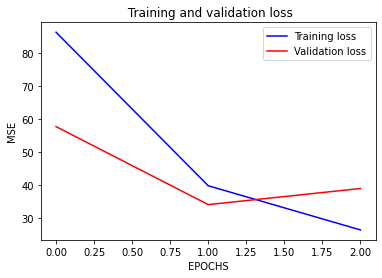

1127/1127 [==============================] - 3s 3ms/sample - loss: 40.6797
MsE average value = 40.68


In [30]:
plot_train_history(attempt12_history, ' Training and validation loss',6,'MSE')
scores = attempt12.evaluate(x_val_multi, y_val_multi, verbose=1)
print(f'MsE average value = {scores:.2f}')

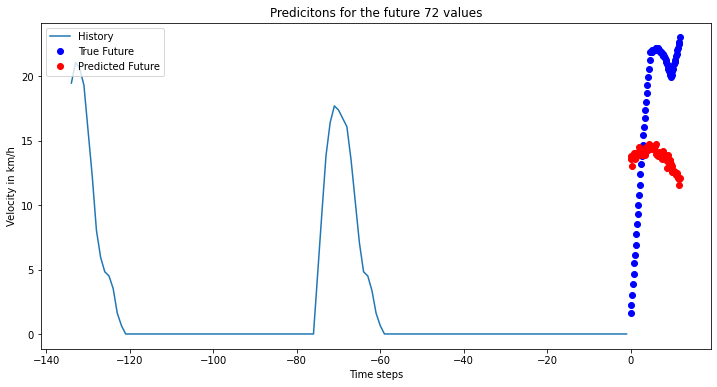

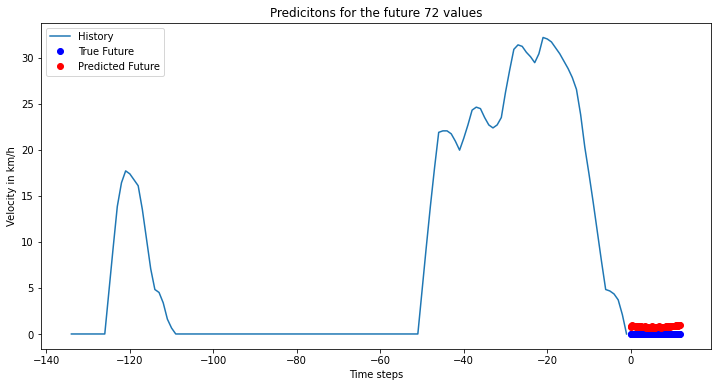

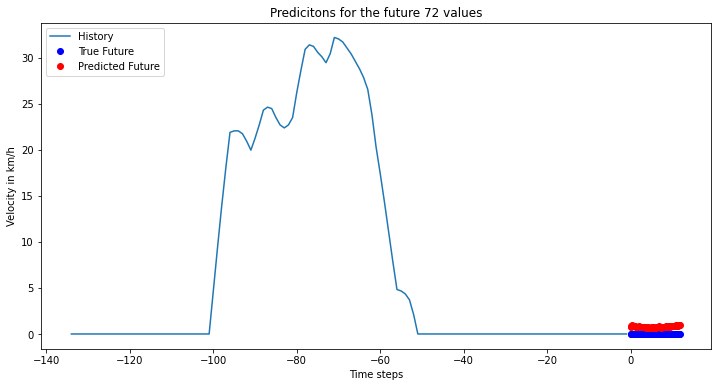

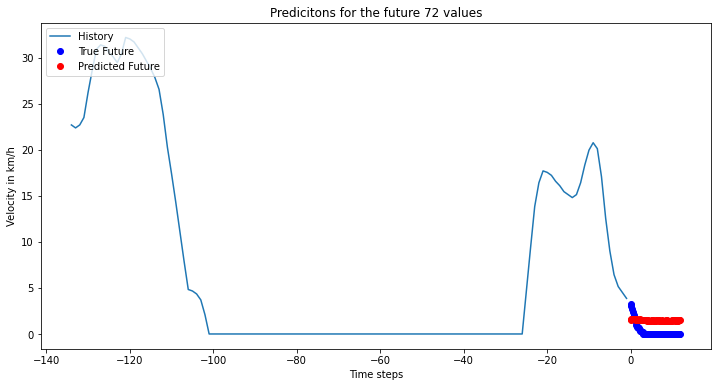

In [31]:
i=1
for x, y in val_data_multi.take(4
                               ):
  multi_step_plot(x[0], y[0], attempt12.predict(x)[0],i)
  i+=1

**ATTEMPT 13**

In [33]:
EPOCHS=3
attempt13 = tf.keras.models.Sequential()
attempt13.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt13.add(tf.keras.layers.LSTM(16, activation='sigmoid',return_sequences=True))
attempt13.add(tf.keras.layers.LSTM(16, activation='sigmoid'))
attempt13.add(tf.keras.layers.Dense(72))

attempt13.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'), loss='mse')

In [34]:
attempt13_history = attempt13.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=100)

Train for 500 steps, validate for 100 steps
Epoch 1/3
500/500 [==============================] - 307s 615ms/step - loss: 94.1490 - val_loss: 81.0567
Epoch 2/3
500/500 [==============================] - 350s 700ms/step - loss: 54.4575 - val_loss: 40.5989
Epoch 3/3
500/500 [==============================] - 293s 586ms/step - loss: 36.7989 - val_loss: 37.6218


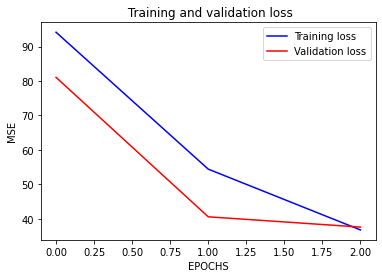

1127/1127 [==============================] - 3s 2ms/sample - loss: 39.9330
MsE average value = 39.93


In [35]:
plot_train_history(attempt13_history, ' Training and validation loss',6,'MSE')
scores = attempt13.evaluate(x_val_multi, y_val_multi, verbose=1)
print(f'MsE average value = {scores:.2f}')

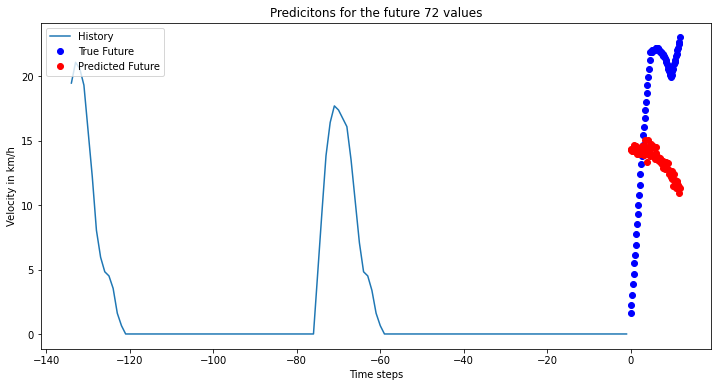

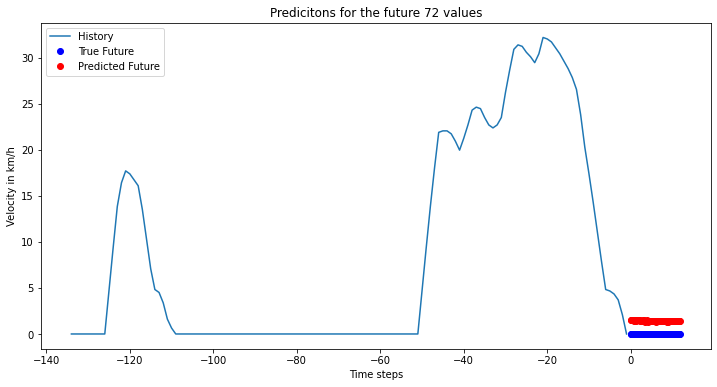

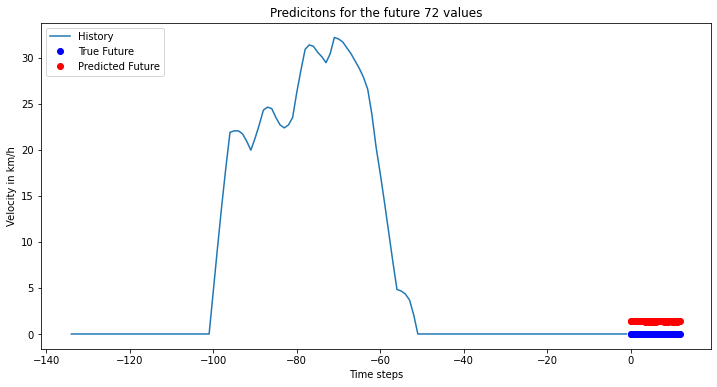

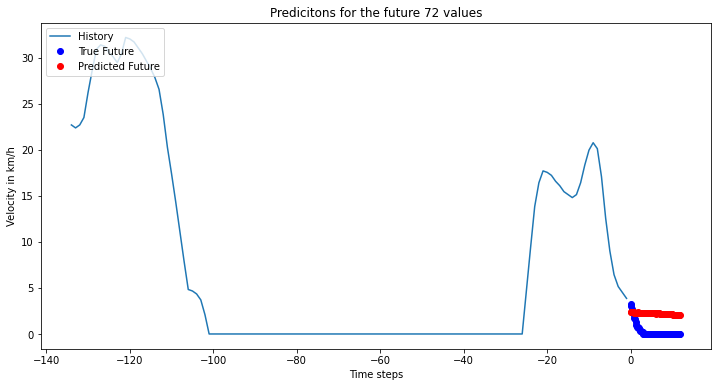

In [36]:
i=1
for x, y in val_data_multi.take(4
                               ):
  multi_step_plot(x[0], y[0], attempt13.predict(x)[0],i)
  i+=1

**ATTEMPT 14**

In [9]:
EPOCHS=10
attempt14 = tf.keras.models.Sequential()
attempt14.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt14.add(tf.keras.layers.LSTM(16, activation='sigmoid',return_sequences=True))
attempt14.add(tf.keras.layers.LSTM(16, activation='sigmoid'))
attempt14.add(tf.keras.layers.Dense(72))

attempt14.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'), loss='mse')

NameError: name 'x_train_multi' is not defined

In [11]:
attempt14_history = attempt14.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=100)

Train for 500 steps, validate for 100 steps
Epoch 1/10
500/500 [==============================] - 264s 528ms/step - loss: 93.1777 - val_loss: 80.1831
Epoch 2/10
500/500 [==============================] - 276s 553ms/step - loss: 53.7682 - val_loss: 44.2728
Epoch 3/10
500/500 [==============================] - 269s 539ms/step - loss: 38.2281 - val_loss: 39.3559
Epoch 4/10
500/500 [==============================] - 264s 528ms/step - loss: 31.0890 - val_loss: 39.5405
Epoch 5/10
500/500 [==============================] - 250s 499ms/step - loss: 26.4286 - val_loss: 43.0681
Epoch 6/10
500/500 [==============================] - 252s 504ms/step - loss: 21.8441 - val_loss: 45.9475
Epoch 7/10
500/500 [==============================] - 239s 477ms/step - loss: 21.0206 - val_loss: 57.1934
Epoch 8/10
500/500 [==============================] - 238s 477ms/step - loss: 16.2294 - val_loss: 42.9219
Epoch 9/10
500/500 [==============================] - 244s 488ms/step - loss: 13.1114 - val_loss: 43.4462
Ep

In [8]:
plot_train_history(attempt14_history, ' Training and validation loss',6,'MSE')
scores = attempt14.evaluate(x_val_multi, y_val_multi, verbose=1)
print(f'MsE average value = {scores:.2f}')

NameError: name 'attempt14_history' is not defined

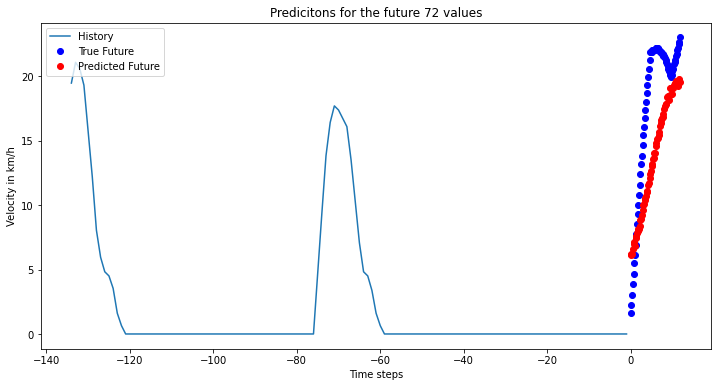

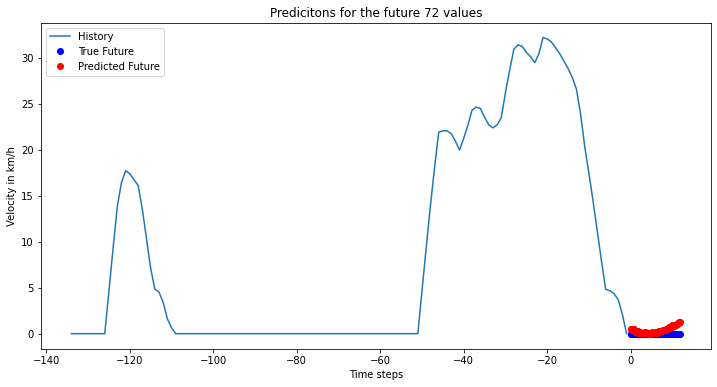

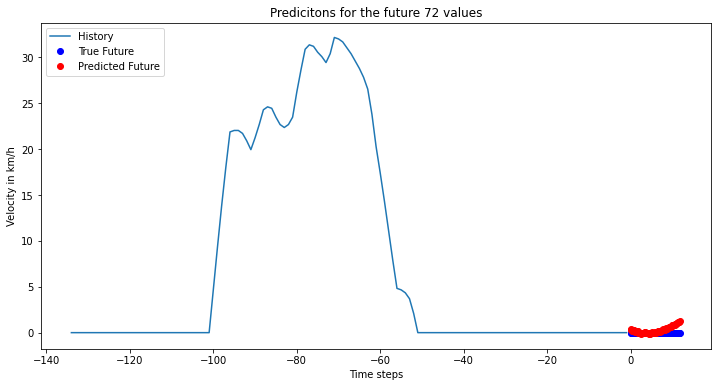

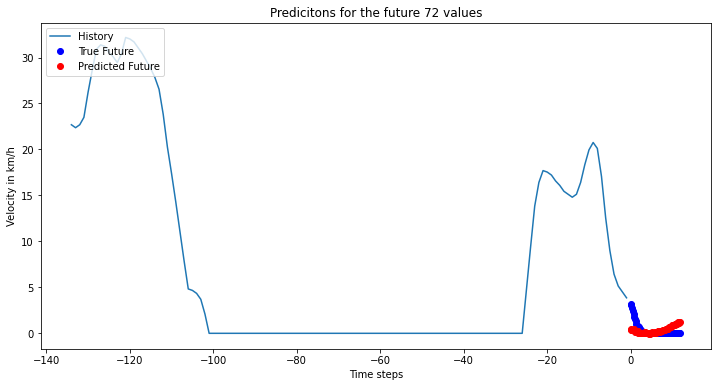

In [13]:
i=1
for x, y in val_data_multi.take(4
                               ):
  multi_step_plot(x[0], y[0], attempt14.predict(x)[0],i)
  i+=1

**ATTEMPT 15: Simulation with new data**

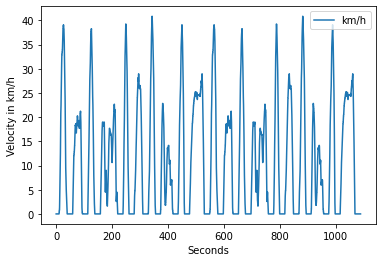

In [17]:
data3.plot()
plt.xlabel('Seconds')
plt.ylabel('Velocity in km/h')
plt.savefig('data3.png')

In [18]:
past_history = 800
future_target = 72
STEP = 6
TRAIN_SPLIT=5000
tf.random.set_seed(13)
BATCH_SIZE = 300 
BUFFER_SIZE = 10000
EVALUATION_INTERVAL = 500
EPOCHS = 5# Amount of times model is going to be trainded



dataframe=pd.concat([data3.shift(1),data3], axis=1)
dataframe.columns = ['t-0.1', 't+0.1']
dataframe=dataframe.dropna()
dataset=dataframe.values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)




train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [19]:
EPOCHS=10
attempt15 = tf.keras.models.Sequential()
attempt15.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
attempt15.add(tf.keras.layers.LSTM(16, activation='sigmoid',return_sequences=True))
attempt15.add(tf.keras.layers.LSTM(16, activation='sigmoid'))
attempt15.add(tf.keras.layers.Dense(72))

attempt15.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'), loss='mse')

In [20]:
attempt15_history = attempt15.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=100)

Train for 500 steps, validate for 100 steps
Epoch 1/10
500/500 [==============================] - 278s 557ms/step - loss: 177.4487 - val_loss: 139.0690
Epoch 2/10
500/500 [==============================] - 283s 565ms/step - loss: 100.5276 - val_loss: 64.8794
Epoch 3/10
500/500 [==============================] - 248s 497ms/step - loss: 54.5926 - val_loss: 41.2425
Epoch 4/10
500/500 [==============================] - 243s 486ms/step - loss: 37.6752 - val_loss: 30.7200
Epoch 5/10
500/500 [==============================] - 237s 475ms/step - loss: 28.1285 - val_loss: 25.7244
Epoch 6/10
500/500 [==============================] - 230s 460ms/step - loss: 23.0157 - val_loss: 21.8962
Epoch 7/10
500/500 [==============================] - 231s 462ms/step - loss: 17.7914 - val_loss: 17.6407
Epoch 8/10
500/500 [==============================] - 235s 470ms/step - loss: 12.9892 - val_loss: 14.4272
Epoch 9/10
500/500 [==============================] - 229s 457ms/step - loss: 9.7846 - val_loss: 11.7575


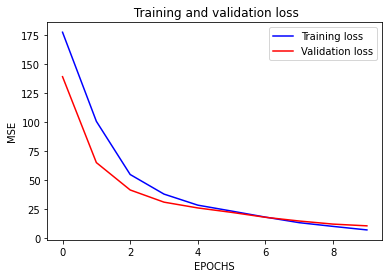

5018/5018 [==============================] - 7s 1ms/sample - loss: 10.8960
MsE average value = 10.90


In [21]:
plot_train_history(attempt15_history, ' Training and validation loss',6,'MSE')
scores = attempt15.evaluate(x_val_multi, y_val_multi, verbose=1)
print(f'MsE average value = {scores:.2f}')

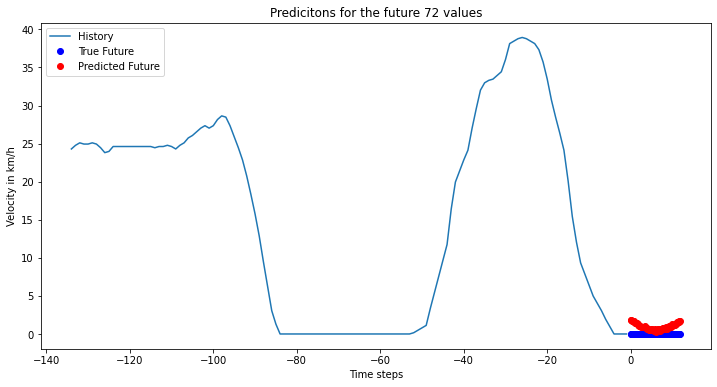

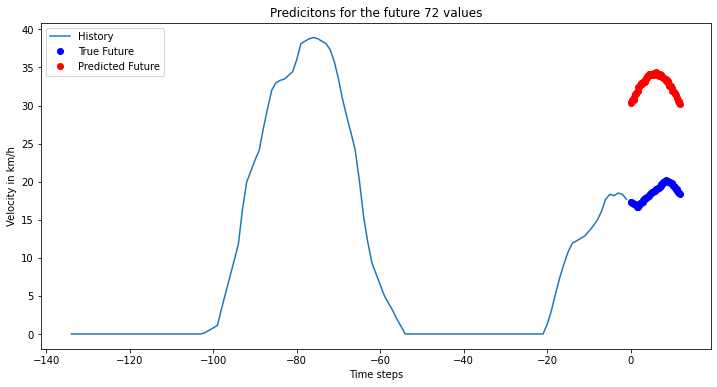

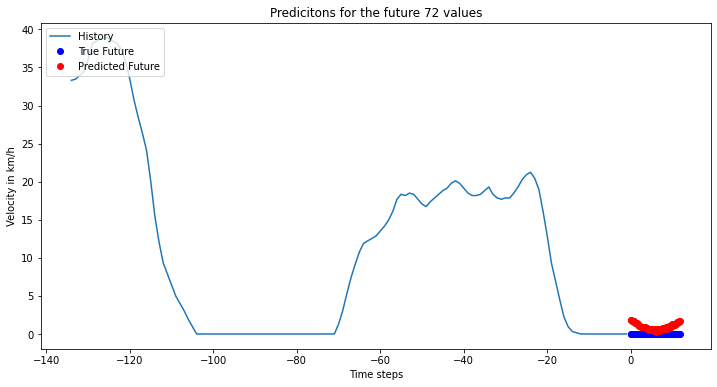

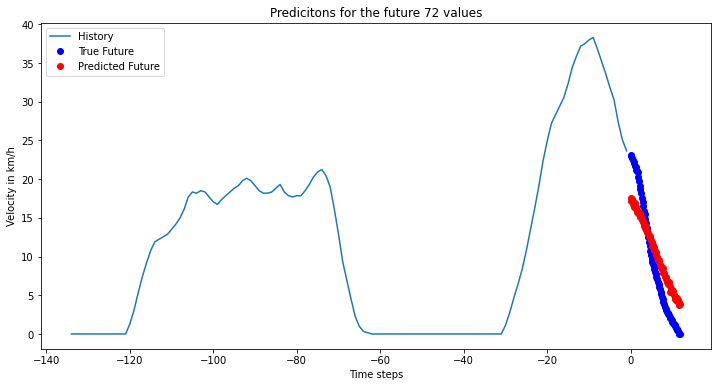

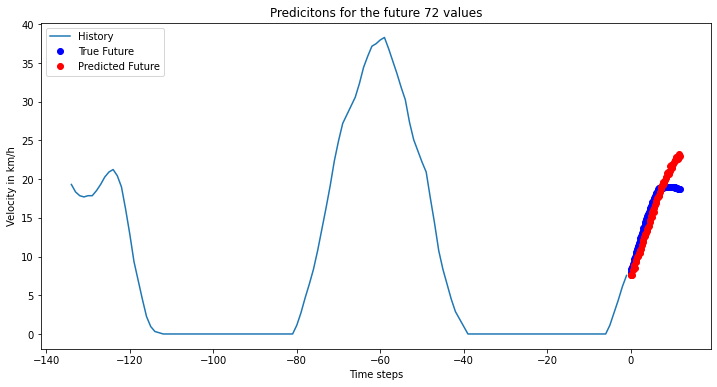

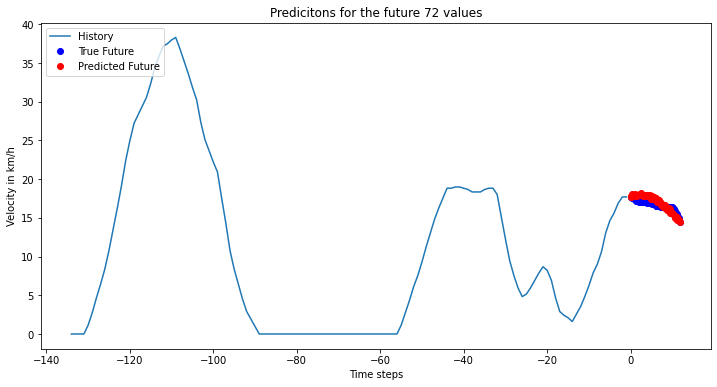

In [24]:
i=1
for x, y in val_data_multi.take(6
                               ):
  multi_step_plot(x[0], y[0], attempt15.predict(x)[0],i)
  i+=1

In [27]:
attempt15.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 134, 32)           4480      
_________________________________________________________________
lstm_1 (LSTM)                (None, 134, 16)           3136      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 72)                1224      
Total params: 10,952
Trainable params: 10,952
Non-trainable params: 0
_________________________________________________________________
